# Exercise A8.1 (e)+(f)

This notebook accompanies the solution to exercise A8.1 and contains a basic implementation of a mini-batch stochastic gradient method for a logistic regression problem of the form
\begin{align*}
        \begin{array}{ll}
            \text{minimize} &  \frac{\gamma}{2} \|x\|_2^2 + \displaystyle \frac1m \sum_{i=1}^m \ln(1+\exp(-y_i a_i^Tx))
        \end{array}
    \end{align*}
    with variable $x\in \mathbb{R}^n$, problem data $(a_i, y_i) \in \mathbb{R}^n \times \{-1,+1\}$ for $i \in \mathbb{N}_m$, and parameter $\gamma > 0$.

We start by importing the necessary libraries and the problem data $y \in \mathbb{R}^m$ and $A \in \mathbb{R}^{m \times n}$ where $a_i^T$ is the $i$th row of $A$ and $y_i$ is the $i$th entry of $y$.

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.io import loadmat

data = loadmat('logreg.mat')
A = data['A']
y = data['y'].ravel()

Next, we implement the logistic loss function and its 1st and 2nd derivatives, i.e.,
$$\phi(t) = \ln(1+\exp(-t)), \quad \phi'(t) = -\frac{\exp(-t)}{1+\exp(-t)}, \quad \phi''(t) = \frac{\exp(-t)}{(1+\exp(-t))^2}.$$
To avoid overflow when $t$ is large, we use the following equivalent expressions:
$$\phi(t) = \ln(1+\exp(-|t|)) - \min(0,t), \quad \phi'(t) = -\frac{\exp(\min(0,-t))}{1+\exp(-|t|)}, \quad \phi''(t) = \frac{\exp(-|t|)}{(1+\exp(-|t|))^2}.$$

In [4]:
def logistic_loss(t):
    """Compute logistic loss, 1st deriv., and sqrt. of 2nd deriv."""
    # f = np.log1p(np.exp(-t))
    # fp = -np.exp(-t)/(1.0+np.exp(-t))
    # fpp = np.exp(-t)/(1.0+np.exp(-t))**2
    tmp = np.exp(-np.abs(t))  
    f =  np.log1p(tmp) - np.minimum(0.0,t)
    fp = -np.exp(np.minimum(0.0,-t))/(1.0+tmp)
    sqrt_fpp = np.sqrt(tmp)/(1.0+tmp)
    return f,fp,sqrt_fpp

Next, we implement the mini-batch stochastic gradient method for the logistic regression problem with a diminishing step size sequence and a mini-batch of size $p$. 

In [5]:
def sgm_logreg(A, y, gamma, p=64, t=1.0, zeta=0.0, delta=0.5, epochs=10):
    """Mini-batch stochastic gradient method for logistic regression"""
    m, n = A.shape
    x = np.zeros(n)
    Niter = np.ceil(epochs*m/p).astype(int)
    fval = np.zeros(Niter+1)
    for k in range(Niter+1):
        S = np.random.choice(m, p, replace=False)
        f,fp,__ = logistic_loss(y[S]*(A[S] @ x))
        fval[k] = gamma/2*np.linalg.norm(x)**2 + np.mean(f)
        grad = gamma*x + 1.0/p * (A[S].T @ (y[S]*fp))
        x -= t/(1+k+zeta)**delta*grad
    return x, fval

We're now ready to run the mini-batch stochastic gradient method on the logistic regression problem for different values of $p$ and $t$.

Text(0.5, 1.0, 'Logistic regression objective value')

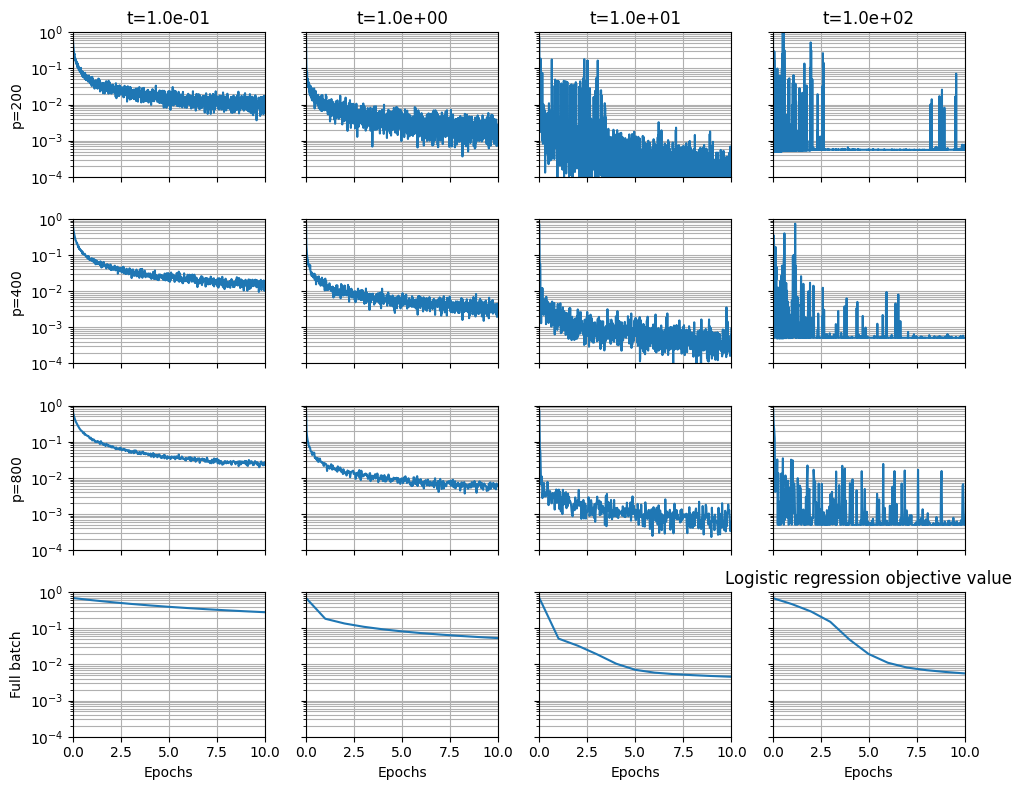

In [6]:
m = A.shape[0]
gamma = 1e-7

T = np.logspace(-1, 2, 4)
P = [200,400,800,m]

plt.figure(figsize=(10,8), tight_layout=True)
for i,p in enumerate(P):
    for j,t in enumerate(T):
        x, fval = sgm_logreg(A, y, gamma=gamma, p=p, t=t, delta=0.0, epochs=10)
        ax = plt.subplot(len(T), len(P), i*len(T)+j+1)
        plt.semilogy(np.arange(len(fval))*p/m, fval)
        plt.ylim([1e-4, 1e0])
        plt.xlim([0, 10])
        ax = plt.gca()
        if i == 0: plt.title('t=%.1e' % (t))
        if j == 0: 
            if p == m: plt.ylabel('Full batch')
            else: plt.ylabel('p=%d' % (p))
        else: 
            ax.tick_params(axis='y', which='both', labelleft=False)
        if i == len(P)-1: 
            plt.xlabel('Epochs')
        else: 
            ax.tick_params(axis='x', which='both', labelbottom=False)
        plt.grid(which='both')
plt.title('Logistic regression objective value')

In [7]:
def nt_logreg(A, y, gamma, maxiter=50, alpha=1e-2, beta=0.5, tol=1e-10):
    """Newton's method for logistic regression"""
    m, n = A.shape
    x = np.zeros(n)

    fval = np.zeros(maxiter+1)
    status = -1
    print('%3s  %12s  %10s  %10s' % ('It','Obj.', 'NT decr', 'Step'))

    for k in range(maxiter+1):
        f,fp,sqrt_fpp = logistic_loss(y*(A @ x))
        fval[k] = gamma/2*np.linalg.norm(x)**2 + np.mean(f)
        grad = gamma*x + 1.0/m * (A.T @ (y*fp))

        # Compute Newton decrement and step
        B = sqrt_fpp[:,np.newaxis]*A
        H = gamma*np.eye(n) + 1.0/m * B.T@B
        L = scipy.linalg.cholesky(H, lower=True)
        dx = scipy.linalg.solve_triangular(L, grad, lower=True)
        ntdecr = np.linalg.norm(dx)
        dx = scipy.linalg.solve_triangular(L.T, -dx)

        # Check stopping criterion
        if ntdecr**2/2 <= tol:
            status = 0
            break

        # Line search
        t = 1.0
        while 0.5*gamma*np.linalg.norm(x+t*dx)**2 + np.mean(logistic_loss(y*(A @ (x+t*dx)))[0]) > fval[k] - alpha*t*ntdecr**2:
            t *= beta

        print('%3d  %12.4e  %10.2e  %10.2e' % (k, fval[k], ntdecr,t))

        # Update x
        x += t*dx

    return x, fval, status

In [8]:
xnt, fvalnt, status = nt_logreg(A, y, gamma)

 It          Obj.     NT decr        Step
  0    6.9315e-01    9.77e-01    1.00e+00
  1    1.4937e-01    3.84e-01    1.00e+00
  2    5.6656e-02    2.31e-01    1.00e+00
  3    2.2794e-02    1.45e-01    1.00e+00
  4    9.4743e-03    9.22e-02    1.00e+00
  5    4.0372e-03    5.99e-02    1.00e+00
  6    1.7428e-03    3.92e-02    1.00e+00
  7    7.5818e-04    2.57e-02    1.00e+00
  8    3.3675e-04    1.67e-02    1.00e+00
  9    1.5777e-04    1.09e-02    1.00e+00
 10    8.2399e-05    7.09e-03    1.00e+00
 11    5.0188e-05    4.68e-03    1.00e+00
 12    3.6316e-05    3.00e-03    1.00e+00
 13    3.0668e-05    1.82e-03    1.00e+00
 14    2.8603e-05    1.00e-03    1.00e+00
 15    2.8018e-05    3.75e-04    1.00e+00
 16    2.7937e-05    1.21e-04    1.00e+00
 17    2.7929e-05    1.55e-05    1.00e+00


In [9]:
x, fval = sgm_logreg(A, y, gamma=gamma, p=800, t=1e2, epochs=10, delta=0.5)

In [10]:
fx = gamma/2.0 * np.linalg.norm(x)**2 + np.mean(logistic_loss(y*(A @ x))[0])
fxnt = gamma/2.0 * np.linalg.norm(xnt)**2 + np.mean(logistic_loss(y*(A @ xnt))[0])

print('f( x ) = %.3e' % (fx))
print('f(xnt) = %.3e' % (fxnt))
print('Relative subopt. : %.3f' % (np.abs(fx-fxnt)/np.abs(fxnt)))
print('Relative error   : %.3f' % (np.linalg.norm(x-xnt)/np.linalg.norm(xnt)))

f( x ) = 2.711e-03
f(xnt) = 2.793e-05
Relative subopt. : 96.072
Relative error   : 4.034
